In [95]:
from IPython.display import display, Markdown
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import RandomForestRegressor
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer, SimpleImputer, KNNImputer
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.tree import DecisionTreeRegressor
import math
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
import pandas as pd 
import scipy.stats as ss
import seaborn as sns
import os
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# Decide between local or kaggle cloud storage         
KAGGLE_ENV = 'kaggle' in os.listdir('/')
data_path = '/kaggle/input' if KAGGLE_ENV else '../kaggle/input'

# This is a good idea to work only locally. But If you wanna ran your NB also at kaggle... this is not working.
# # Pull the dataset from kaggle, it is concat dataset train + original dataset
# dataset_name = 'dantheshark/s4-e11-train-concat'
# if KAGGLE_ENV:
#     kaggle.api.dataset_download_files(dataset_name, path="../kaggle/input/", unzip=True)


for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))
    
for dirname, _, filenames in os.walk(data_path):
    for filename in filenames:
        print(os.path.join(dirname, filename)) 

../kaggle/input/playground-series-s5e4/sample_submission.csv
../kaggle/input/playground-series-s5e4/test.csv
../kaggle/input/playground-series-s5e4/train.csv
../kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset.csv
../kaggle/input/podcast-listening-time-prediction-dataset/podcast_dataset_info.txt


# Load Data

In [96]:
# Load the data
train_original = pd.read_csv(data_path + '/playground-series-s5e4/train.csv')
test_original = pd.read_csv(data_path + '/playground-series-s5e4/test.csv')
sample_submission = pd.read_csv(data_path + '/playground-series-s5e4/sample_submission.csv')

original_data = pd.read_csv(data_path + '/podcast-listening-time-prediction-dataset/podcast_dataset.csv')

In [97]:
#Concat train and the original data set
train_original.drop('id', axis=1, inplace=True) #id is not needed for training
train = train_original.copy()
train = pd.concat([train, original_data],ignore_index=True)

test = test_original.copy()
test.drop('id', axis=1, inplace=True) #id is not needed for testing

In [98]:
train.iloc[train_original.shape[0]-5:train_original.shape[0]+5].head(10)

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
749995,Learning Lab,Episode 25,75.66,Education,69.36,Saturday,Morning,NaN,0.0,Negative,56.870580
749996,Business Briefs,Episode 21,75.75,Business,35.21,Saturday,Night,NaN,2.0,Neutral,45.462420
749997,Lifestyle Lounge,Episode 51,30.98,Lifestyle,78.58,Thursday,Morning,84.89,0.0,Negative,15.260000
749998,Style Guide,Episode 47,108.98,Lifestyle,45.39,Thursday,Morning,93.27,0.0,Negative,100.729390
749999,Sports Central,Episode 99,24.10,Sports,22.45,Saturday,Night,36.72,0.0,Neutral,11.944390
750000,Healthy Living,Episode 77,99.25,Health,21.37,Thursday,Night,70.22,3.0,Positive,55.158695
750001,Mystery Matters,Episode 6,19.43,True Crime,47.19,Friday,Evening,75.15,1.0,Neutral,7.686559
750002,Current Affairs,Episode 1,117.03,News,96.33,Sunday,Night,57.95,3.0,Neutral,110.064645
750003,Mystery Matters,Episode 38,16.97,True Crime,25.73,Monday,Night,24.19,0.0,Positive,12.000380
750004,Humor Hub,Episode 73,83.48,Comedy,76.69,Tuesday,Afternoon,42.31,3.0,Positive,NaN


# Save concat Dataset

In [99]:
# Save concat Dataset
train.to_csv('train_concat.csv', index=False)

# Preprocessing

## Train Dataset

### Convert features if needed

#### Convert object to category
Some of the features are redundant - lets convert them to category.

In [100]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802500 entries, 0 to 802499
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 802500 non-null  object 
 1   Episode_Title                802500 non-null  object 
 2   Episode_Length_minutes       710161 non-null  float64
 3   Genre                        802500 non-null  object 
 4   Host_Popularity_percentage   802500 non-null  float64
 5   Publication_Day              802500 non-null  object 
 6   Publication_Time             802500 non-null  object 
 7   Guest_Popularity_percentage  651212 non-null  float64
 8   Number_of_Ads                802499 non-null  float64
 9   Episode_Sentiment            802500 non-null  object 
 10  Listening_Time_minutes       797105 non-null  float64
dtypes: float64(5), object(6)
memory usage: 67.3+ MB


In [101]:
def convert_object_to_category(df, max_unique_values=50):
    """
    Converts all object columns to category
    if the number of unique values is below max_unique_values.
    """
    for col in df.select_dtypes(include='object').columns:
        if df[col].nunique() <= max_unique_values:
            df[col] = df[col].astype('category')
            print(f"Converted {col} to category")
    return df

In [102]:
convert_object_to_category(train)

Converted Podcast_Name to category
Converted Genre to category
Converted Publication_Day to category
Converted Publication_Time to category
Converted Episode_Sentiment to category


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
0,Mystery Matters,Episode 98,NaN,True Crime,74.81,Thursday,Night,NaN,0.0,Positive,31.419980
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.012410
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.925310
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.278240
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.610310
...,...,...,...,...,...,...,...,...,...,...,...
802495,Home & Living,Episode 17,24.81,Lifestyle,66.15,Monday,Evening,98.63,1.0,Neutral,20.573795
802496,Melody Mix,Episode 9,92.15,Music,89.61,Saturday,Night,25.82,2.0,Negative,76.198459
802497,Comedy Corner,Episode 24,112.27,Comedy,26.33,Saturday,Night,55.29,0.0,Neutral,107.602135
802498,Business Briefs,Episode 85,NaN,Business,41.47,Wednesday,Afternoon,33.58,0.0,Neutral,17.220998


In [103]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802500 entries, 0 to 802499
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 802500 non-null  category
 1   Episode_Title                802500 non-null  object  
 2   Episode_Length_minutes       710161 non-null  float64 
 3   Genre                        802500 non-null  category
 4   Host_Popularity_percentage   802500 non-null  float64 
 5   Publication_Day              802500 non-null  category
 6   Publication_Time             802500 non-null  category
 7   Guest_Popularity_percentage  651212 non-null  float64 
 8   Number_of_Ads                802499 non-null  float64 
 9   Episode_Sentiment            802500 non-null  category
 10  Listening_Time_minutes       797105 non-null  float64 
dtypes: category(5), float64(5), object(1)
memory usage: 40.6+ MB


#### Convert float to int
Not needed

In [104]:
# # Convert Float to Int, not needed float
# columns_to_convert = [] # list of columns to convert

# for col in columns_to_convert:
#     train[col] = pd.to_numeric(train[col], errors='coerce').astype('Int64')
#     train[col] = pd.to_numeric(train[col], errors='coerce').astype('Int64')

### Outliers

#### Delete numerical Outliers

In [105]:
numeric_features = train.select_dtypes(include=['int64', 'float64']).columns

In [106]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 802500 entries, 0 to 802499
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 802500 non-null  category
 1   Episode_Title                802500 non-null  object  
 2   Episode_Length_minutes       710161 non-null  float64 
 3   Genre                        802500 non-null  category
 4   Host_Popularity_percentage   802500 non-null  float64 
 5   Publication_Day              802500 non-null  category
 6   Publication_Time             802500 non-null  category
 7   Guest_Popularity_percentage  651212 non-null  float64 
 8   Number_of_Ads                802499 non-null  float64 
 9   Episode_Sentiment            802500 non-null  category
 10  Listening_Time_minutes       797105 non-null  float64 
dtypes: category(5), float64(5), object(1)
memory usage: 40.6+ MB


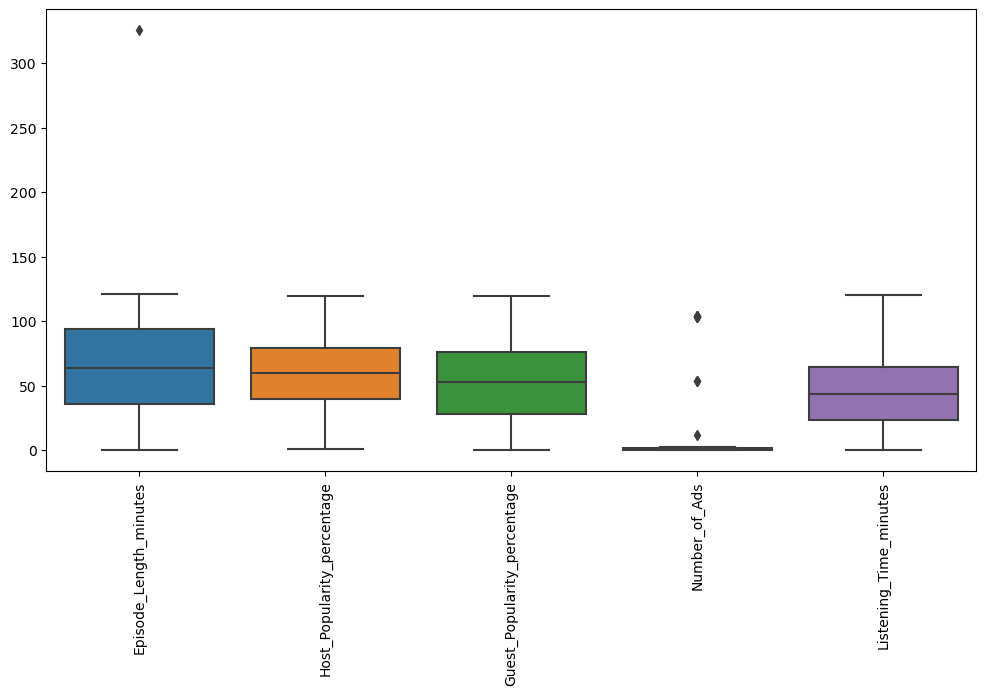

In [107]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train[numeric_features])
plt.xticks(rotation=90)
plt.show()

In [108]:
train.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,710161.000000,802500.000000,651212.000000,802499.000000,797105.000000
mean,64.394865,59.879792,52.078083,1.358610,45.444668
std,32.983341,22.891991,28.488536,1.149546,27.140915
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.670000,39.460000,28.070000,0.000000,23.184220
50%,63.740000,60.060000,53.320000,1.000000,43.392270
75%,93.980000,79.560000,76.480000,2.000000,64.814620
max,325.240000,119.460000,119.910000,103.910000,119.970000


In [109]:
# Check what kind of Episodes are they?
train_long_episodes = train[train['Episode_Length_minutes'] >= 150]
train_long_episodes.head()
# Lets delete it... not sure about it.

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
101637,Home & Living,Episode 16,325.24,Lifestyle,50.69,Tuesday,Afternoon,15.01,0.0,Positive,64.31981


In [110]:
# Lets have a look..
train_long_episodes = train[train['Number_of_Ads'] >= 10]
train_long_episodes.head()
# Lets delete it... not sure about it.

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
211159,Wellness Wave,Episode 83,64.83,Health,48.46,Sunday,Evening,NaN,53.37,Positive,50.44892
283606,Health Hour,Episode 15,109.93,Health,67.81,Sunday,Morning,77.90,103.91,Neutral,103.89696
436577,Sports Central,Episode 64,115.25,Sports,28.58,Saturday,Afternoon,23.65,103.00,Neutral,103.12686
495919,Comedy Corner,Episode 79,64.83,Comedy,48.37,Saturday,Evening,NaN,53.42,Neutral,50.44892
537705,Sound Waves,Episode 64,112.27,Music,28.95,Saturday,Morning,10.15,103.75,Neutral,103.12686


In [111]:
train = train[train['Episode_Length_minutes'] <= 150]
train = train[train['Number_of_Ads'] <= 10]

In [112]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Index: 710150 entries, 1 to 802499
Data columns (total 11 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 710150 non-null  category
 1   Episode_Title                710150 non-null  object  
 2   Episode_Length_minutes       710150 non-null  float64 
 3   Genre                        710150 non-null  category
 4   Host_Popularity_percentage   710150 non-null  float64 
 5   Publication_Day              710150 non-null  category
 6   Publication_Time             710150 non-null  category
 7   Guest_Popularity_percentage  581561 non-null  float64 
 8   Number_of_Ads                710150 non-null  float64 
 9   Episode_Sentiment            710150 non-null  category
 10  Listening_Time_minutes       705306 non-null  float64 
dtypes: category(5), float64(5), object(1)
memory usage: 41.3+ MB


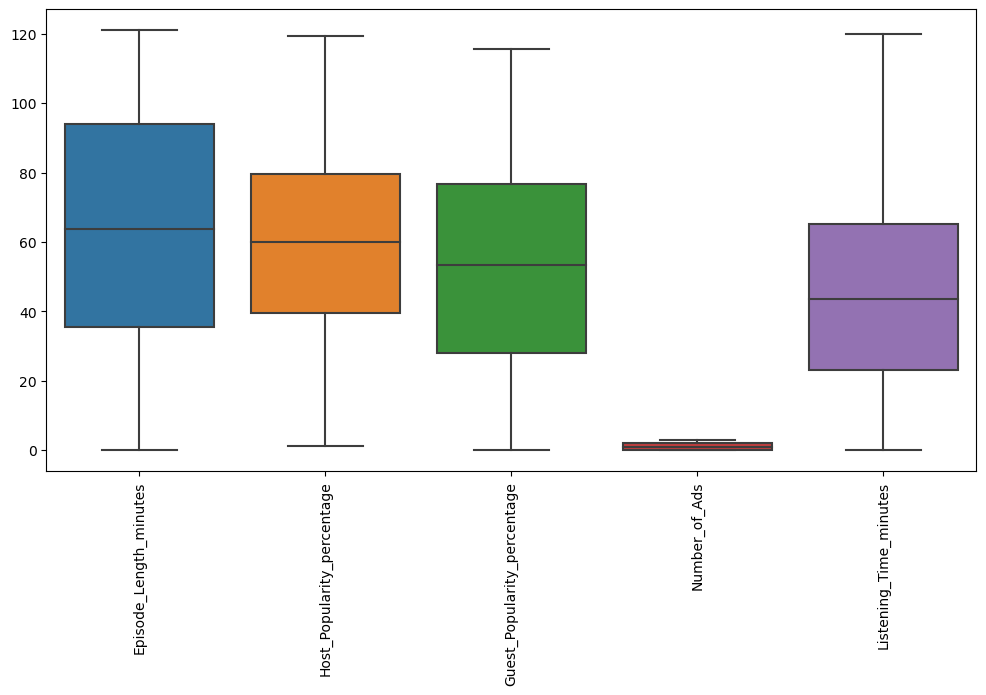

In [113]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=train[numeric_features])
plt.xticks(rotation=90)
plt.show()

In [114]:
train.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,710150.000000,710150.000000,581561.000000,710150.000000,705306.000000
mean,64.394198,59.894245,52.072042,1.360549,45.728920
std,32.981779,22.888900,28.546671,1.111775,27.261742
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.670000,39.500000,27.960000,0.000000,23.260250
50%,63.740000,60.090000,53.370000,1.000000,43.730000
75%,93.980000,79.570000,76.570000,2.000000,65.185500
max,120.930000,119.460000,115.620000,3.000000,119.970000


### Check Redundant Data

In [115]:
print(train.duplicated().sum())
print(train.duplicated(subset=['Podcast_Name', 'Episode_Title']).sum())
# Be careful, playground datasets are artifically created, so It is possible we have variatnion in the data.
# Conclusion: Only delete the 1:1 duplicates.
train = train.drop_duplicates()


2279
705350


In [116]:
print(train.duplicated().sum())

0


### Show general stats

In [117]:
def show_general_stats(df):
    display(Markdown('### General Stats'))
    display(df.describe())
    display(Markdown('### Data Types'))
    display(df.dtypes)
    display(Markdown('### Missing Values'))
    display(df.isnull().sum())
    display(Markdown('### Shape'))
    display(df.shape)
    display(Markdown('### Head'))
    display(df.head(100))
    display(Markdown('### Tail'))
    display(df.tail(100))
    display(Markdown('### Sample'))
    display(df.sample(100))
    display(Markdown('### '))

In [118]:
show_general_stats(train)

### General Stats

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes
count,707871.000000,707871.000000,579522.000000,707871.000000,703270.000000
mean,64.399262,59.892578,52.082746,1.360169,45.727890
std,32.980779,22.887224,28.543809,1.111735,27.259659
min,0.000000,1.300000,0.000000,0.000000,0.000000
25%,35.670000,39.500000,27.980000,0.000000,23.260251
50%,63.760000,60.090000,53.370000,1.000000,43.731430
75%,93.990000,79.570000,76.590000,2.000000,65.184160
max,120.930000,119.460000,115.620000,3.000000,119.970000


### Data Types

Podcast_Name                   category
Episode_Title                    object
Episode_Length_minutes          float64
Genre                          category
Host_Popularity_percentage      float64
Publication_Day                category
Publication_Time               category
Guest_Popularity_percentage     float64
Number_of_Ads                   float64
Episode_Sentiment              category
Listening_Time_minutes          float64
dtype: object

### Missing Values

Podcast_Name                        0
Episode_Title                       0
Episode_Length_minutes              0
Genre                               0
Host_Popularity_percentage          0
Publication_Day                     0
Publication_Time                    0
Guest_Popularity_percentage    128349
Number_of_Ads                       0
Episode_Sentiment                   0
Listening_Time_minutes           4601
dtype: int64

### Shape

(707871, 11)

### Head

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
1,Joke Junction,Episode 26,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241
2,Study Sessions,Episode 16,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531
3,Digital Digest,Episode 45,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824
4,Mind & Body,Episode 86,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031
5,Fitness First,Episode 19,26.54,Health,48.96,Saturday,Afternoon,NaN,3.0,Positive,22.77047
...,...,...,...,...,...,...,...,...,...,...,...
107,Daily Digest,Episode 96,37.31,News,57.78,Friday,Afternoon,5.62,1.0,Neutral,9.77975
108,Tech Trends,Episode 78,85.12,Technology,62.19,Friday,Morning,9.00,2.0,Positive,58.26835
109,Crime Chronicles,Episode 96,80.33,True Crime,64.13,Thursday,Evening,44.07,0.0,Positive,53.21997
110,Life Lessons,Episode 6,21.48,Lifestyle,53.04,Sunday,Night,11.78,0.0,Negative,12.46019


### Tail

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
799889,Mind & Body,Episode 78,11.31,Health,58.31,Saturday,Night,NaN,1.0,Positive,0.629263
799890,Sports Central,Episode 53,48.18,Sports,38.98,Thursday,Afternoon,63.56,2.0,Positive,45.722005
799891,Funny Folks,Episode 2,111.81,Comedy,61.41,Monday,Evening,15.12,2.0,Positive,64.953933
799892,Humor Hub,Episode 90,50.48,Comedy,56.32,Saturday,Afternoon,NaN,2.0,Negative,45.007477
799893,Sport Spot,Episode 9,105.29,Sports,66.37,Sunday,Afternoon,34.13,1.0,Positive,96.141611
...,...,...,...,...,...,...,...,...,...,...,...
799995,Educational Nuggets,Episode 53,41.64,Education,95.89,Wednesday,Morning,28.55,1.0,Neutral,NaN
799996,Brain Boost,Episode 12,89.78,Education,93.08,Saturday,Evening,93.12,3.0,Positive,56.795223
799997,Tech Trends,Episode 18,77.86,Technology,41.04,Saturday,Afternoon,52.33,2.0,Positive,46.797187
799998,Business Insights,Episode 23,84.53,Business,60.80,Saturday,Afternoon,49.10,0.0,Negative,NaN


### Sample

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes
757882,Global News,Episode 59,46.29,News,62.72,Saturday,Evening,79.48,0.0,Negative,34.596514
258201,Gadget Geek,Episode 78,7.51,Technology,49.26,Tuesday,Morning,23.33,2.0,Positive,6.391850
359986,Global News,Episode 95,107.90,News,95.34,Monday,Night,NaN,3.0,Neutral,86.793970
3045,Music Matters,Episode 15,22.37,Music,66.87,Monday,Night,28.61,1.0,Negative,10.906900
745066,Lifestyle Lounge,Episode 52,30.61,Lifestyle,32.70,Tuesday,Morning,66.96,0.0,Positive,20.541440
...,...,...,...,...,...,...,...,...,...,...,...
21636,Innovators,Episode 2,104.28,Technology,62.33,Wednesday,Afternoon,46.68,2.0,Negative,93.433750
495596,Innovators,Episode 37,62.67,Technology,79.65,Friday,Evening,22.18,1.0,Negative,42.083580
579421,Global News,Episode 66,35.99,News,53.46,Sunday,Night,29.11,0.0,Negative,29.021500
625027,Gadget Geek,Episode 37,68.60,Technology,95.84,Sunday,Night,95.45,3.0,Negative,67.761970


### 

### Numerical missing data fix

In [119]:
# 1. Guest_Popularity: missing = no guest (0), add flag
train['has_guest'] = (~train['Guest_Popularity_percentage'].isna()).astype(int)
train['Guest_Popularity_percentage'].fillna(0, inplace=True)

# 2. Episode_Length: Median
train['Episode_Length_minutes'].fillna(train['Episode_Length_minutes'].mean(), inplace=True)

# 3. Listening_Time: only data with data!
train = train[train['Listening_Time_minutes'].notna()]

# 4. Number_of_Ads: 0
train['Number_of_Ads'].fillna(0, inplace=True)

In [120]:
train.isnull().sum()

Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
Listening_Time_minutes         0
has_guest                      0
dtype: int64

### Categorical missing data fix
Not needed

## Test Data set

### Convert features if needed

In [121]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Podcast_Name                 250000 non-null  object 
 1   Episode_Title                250000 non-null  object 
 2   Episode_Length_minutes       221264 non-null  float64
 3   Genre                        250000 non-null  object 
 4   Host_Popularity_percentage   250000 non-null  float64
 5   Publication_Day              250000 non-null  object 
 6   Publication_Time             250000 non-null  object 
 7   Guest_Popularity_percentage  201168 non-null  float64
 8   Number_of_Ads                250000 non-null  float64
 9   Episode_Sentiment            250000 non-null  object 
dtypes: float64(4), object(6)
memory usage: 19.1+ MB


In [122]:
convert_object_to_category(test)

Converted Podcast_Name to category
Converted Genre to category
Converted Publication_Day to category
Converted Publication_Time to category
Converted Episode_Sentiment to category


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral
...,...,...,...,...,...,...,...,...,...,...
249995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive


In [123]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 250000 non-null  category
 1   Episode_Title                250000 non-null  object  
 2   Episode_Length_minutes       221264 non-null  float64 
 3   Genre                        250000 non-null  category
 4   Host_Popularity_percentage   250000 non-null  float64 
 5   Publication_Day              250000 non-null  category
 6   Publication_Time             250000 non-null  category
 7   Guest_Popularity_percentage  201168 non-null  float64 
 8   Number_of_Ads                250000 non-null  float64 
 9   Episode_Sentiment            250000 non-null  category
dtypes: category(5), float64(4), object(1)
memory usage: 10.7+ MB


#### Convert float to int
not needed

### Outliers

#### Delete numerical Outliers

In [124]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 250000 entries, 0 to 249999
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 250000 non-null  category
 1   Episode_Title                250000 non-null  object  
 2   Episode_Length_minutes       221264 non-null  float64 
 3   Genre                        250000 non-null  category
 4   Host_Popularity_percentage   250000 non-null  float64 
 5   Publication_Day              250000 non-null  category
 6   Publication_Time             250000 non-null  category
 7   Guest_Popularity_percentage  201168 non-null  float64 
 8   Number_of_Ads                250000 non-null  float64 
 9   Episode_Sentiment            250000 non-null  category
dtypes: category(5), float64(4), object(1)
memory usage: 10.7+ MB


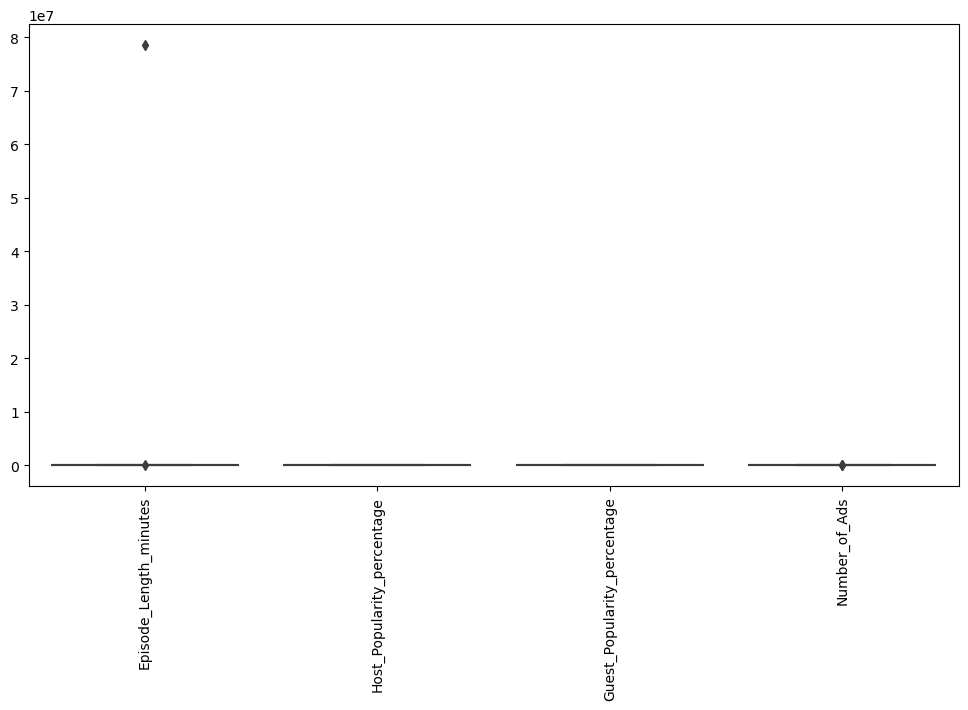

In [125]:
numeric_features = test.select_dtypes(include=['int64', 'float64']).columns
plt.figure(figsize=(12, 6))
sns.boxplot(data=test[numeric_features])
plt.xticks(rotation=90)
plt.show()

In [126]:
test.describe()

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,2.212640e+05,250000.000000,201168.000000,250000.000000
mean,4.192987e+02,59.716491,52.192796,1.355852
std,1.668545e+05,22.880028,28.445034,4.274399
min,2.470000e+00,2.490000,0.000000,0.000000
25%,3.578000e+01,39.250000,28.320000,0.000000
50%,6.397000e+01,59.900000,53.360000,1.000000
75%,9.415000e+01,79.390000,76.560000,2.000000
max,7.848626e+07,117.760000,116.820000,2063.000000


In [127]:
# Check what kind of Episodes are they?
test_long_episodes = test[test['Episode_Length_minutes'] >= 150]
test_long_episodes.head()
# Lets delete it.. way to huge!

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
54434,Current Affairs,Episode 36,7575.0,News,89.54,Saturday,Night,NaN,2.0,Negative
56597,Market Masters,Episode 23,78486264.0,Business,55.45,Monday,Evening,48.5,0.0,Positive


In [128]:
test = test[test['Episode_Length_minutes'] <= 150]

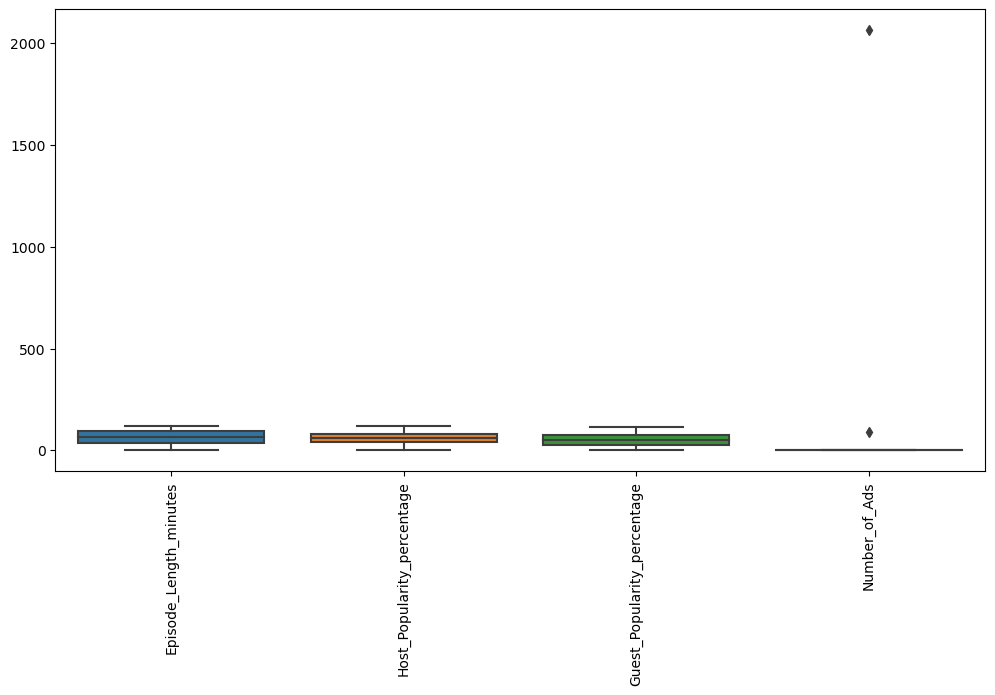

In [129]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=test[numeric_features])
plt.xticks(rotation=90)
plt.show()

In [130]:
test_number_of_ads = test[test['Number_of_Ads'] > 10]
test_number_of_ads.head()
# Does not look plausible, lets delete it.


,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
37939,Life Lessons,Episode 94,89.84,Lifestyle,60.79,Sunday,Afternoon,62.13,89.12,Neutral
178393,Tech Trends,Episode 59,7.15,Technology,71.90,Sunday,Morning,17.39,2063.00,Positive


In [131]:
test = test[test['Number_of_Ads'] <= 10]
test.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221260 entries, 0 to 249999
Data columns (total 10 columns):
 #   Column                       Non-Null Count   Dtype   
---  ------                       --------------   -----   
 0   Podcast_Name                 221260 non-null  category
 1   Episode_Title                221260 non-null  object  
 2   Episode_Length_minutes       221260 non-null  float64 
 3   Genre                        221260 non-null  category
 4   Host_Popularity_percentage   221260 non-null  float64 
 5   Publication_Day              221260 non-null  category
 6   Publication_Time             221260 non-null  category
 7   Guest_Popularity_percentage  179831 non-null  float64 
 8   Number_of_Ads                221260 non-null  float64 
 9   Episode_Sentiment            221260 non-null  category
dtypes: category(5), float64(4), object(1)
memory usage: 11.2+ MB


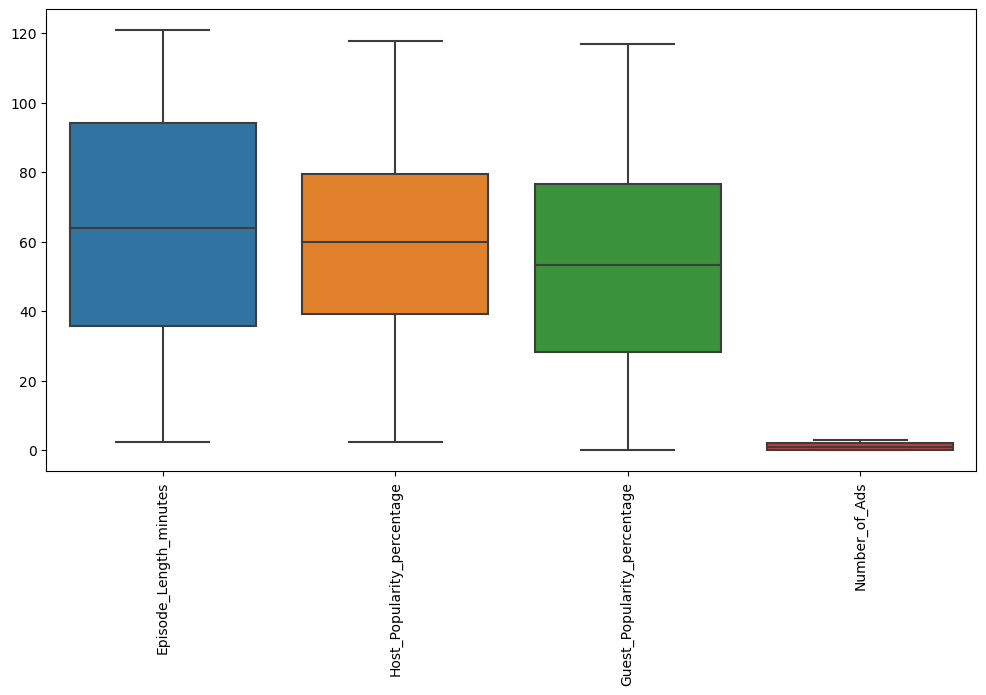

In [132]:
plt.figure(figsize=(12, 6))
sns.boxplot(data=test[numeric_features])
plt.xticks(rotation=90)
plt.show()

### Check Redundant Data

In [133]:
print(test.duplicated().sum())
# print(train.duplicated(subset=['Podcast_Name', 'Episode_Title']).sum())
# # Be careful, playground datasets are artifically created, so It is possible we have variatnion in the data.
# # Conclusion: Only delete the 1:1 duplicates.
# train = train.drop_duplicates()

0


### Show general stats

In [134]:
show_general_stats(test)

### General Stats

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads
count,221260.000000,221260.000000,179831.000000,221260.000000
mean,64.547504,59.729756,52.184786,1.348355
std,32.952956,22.883193,28.510411,1.112342
min,2.470000,2.490000,0.000000,0.000000
25%,35.780000,39.270000,28.210000,0.000000
50%,63.970000,59.910000,53.380000,1.000000
75%,94.150000,79.400000,76.650000,2.000000
max,120.730000,117.760000,116.820000,3.000000


### Data Types

Podcast_Name                   category
Episode_Title                    object
Episode_Length_minutes          float64
Genre                          category
Host_Popularity_percentage      float64
Publication_Day                category
Publication_Time               category
Guest_Popularity_percentage     float64
Number_of_Ads                   float64
Episode_Sentiment              category
dtype: object

### Missing Values

Podcast_Name                       0
Episode_Title                      0
Episode_Length_minutes             0
Genre                              0
Host_Popularity_percentage         0
Publication_Day                    0
Publication_Time                   0
Guest_Popularity_percentage    41429
Number_of_Ads                      0
Episode_Sentiment                  0
dtype: int64

### Shape

(221260, 10)

### Head

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
0,Educational Nuggets,Episode 73,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral
1,Sound Waves,Episode 23,27.87,Music,71.29,Sunday,Morning,NaN,0.0,Neutral
2,Joke Junction,Episode 11,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive
3,Comedy Corner,Episode 73,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive
4,Life Lessons,Episode 50,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral
...,...,...,...,...,...,...,...,...,...,...
106,Game Day,Episode 46,43.54,Sports,41.46,Thursday,Afternoon,92.77,0.0,Negative
107,Fashion Forward,Episode 64,112.27,Lifestyle,78.48,Saturday,Night,55.29,0.0,Positive
108,Sport Spot,Episode 94,93.88,Sports,54.53,Wednesday,Evening,35.03,3.0,Neutral
109,Life Lessons,Episode 79,53.76,Lifestyle,40.46,Thursday,Evening,45.03,0.0,Negative


### Tail

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
249888,Humor Hub,Episode 80,102.65,Comedy,99.69,Saturday,Afternoon,78.03,1.0,Neutral
249889,Wellness Wave,Episode 73,20.80,Health,37.51,Thursday,Afternoon,95.12,2.0,Negative
249890,True Crime Stories,Episode 78,80.15,True Crime,44.66,Sunday,Afternoon,19.16,0.0,Negative
249892,Digital Digest,Episode 23,71.90,Technology,68.30,Saturday,Afternoon,NaN,2.0,Positive
249893,Daily Digest,Episode 15,118.16,News,78.18,Tuesday,Evening,87.16,0.0,Positive
...,...,...,...,...,...,...,...,...,...,...
249995,Mind & Body,Episode 100,21.05,Health,65.77,Saturday,Evening,96.40,3.0,Negative
249996,Joke Junction,Episode 85,85.50,Comedy,41.47,Saturday,Night,30.52,2.0,Negative
249997,Joke Junction,Episode 63,12.11,Comedy,25.92,Thursday,Evening,73.69,1.0,Neutral
249998,Market Masters,Episode 46,113.46,Business,43.47,Friday,Night,93.59,3.0,Positive


### Sample

,Podcast_Name,Episode_Title,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment
85183,Educational Nuggets,Episode 92,11.71,Education,37.71,Tuesday,Evening,34.77,0.0,Negative
167632,Market Masters,Episode 73,53.56,Business,72.25,Wednesday,Evening,NaN,3.0,Neutral
163649,Digital Digest,Episode 48,23.68,Technology,26.94,Thursday,Evening,24.59,1.0,Positive
126092,Innovators,Episode 1,46.20,Technology,40.84,Tuesday,Evening,98.76,3.0,Positive
209643,Criminal Minds,Episode 37,44.03,True Crime,37.36,Sunday,Evening,11.22,0.0,Neutral
...,...,...,...,...,...,...,...,...,...,...
186634,Learning Lab,Episode 8,111.73,Education,31.05,Sunday,Night,7.73,1.0,Positive
100524,Detective Diaries,Episode 19,49.32,True Crime,41.28,Saturday,Night,43.03,0.0,Negative
48811,Humor Hub,Episode 62,31.53,Comedy,61.09,Friday,Afternoon,82.36,0.0,Negative
161964,Tech Talks,Episode 13,78.04,Technology,46.91,Wednesday,Evening,NaN,3.0,Negative


### 

### Numerical missing data fix

In [135]:
# 1. Guest_Popularity: missing = no guest (0), add flag
test['has_guest'] = (~test['Guest_Popularity_percentage'].isna()).astype(int)
test['Guest_Popularity_percentage'].fillna(0, inplace=True)

In [136]:
test.isnull().sum()

Podcast_Name                   0
Episode_Title                  0
Episode_Length_minutes         0
Genre                          0
Host_Popularity_percentage     0
Publication_Day                0
Publication_Time               0
Guest_Popularity_percentage    0
Number_of_Ads                  0
Episode_Sentiment              0
has_guest                      0
dtype: int64

#### Categorical missing data fix
not needed

# Scaling

## Scale Numerical features - Train
Not yet, will do a test with xgboost, no scaling is needed

## Scale Categorical Features - Train

In [137]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = train.copy()

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_feature = encoder.fit_transform(df[['Episode_Title']])
df_encoded = pd.DataFrame(encoded_feature, columns=encoder.get_feature_names_out(['Episode_Title']))

df = df.drop(columns=['Episode_Title'])
df = pd.concat([df, df_encoded], axis=1)

# Final DataFrame
train = df.copy()

# Show stats
show_general_stats(train)

### General Stats

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,Listening_Time_minutes,has_guest,Episode_Title_Episode 1,Episode_Title_Episode 10,Episode_Title_Episode 100,Episode_Title_Episode 11,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
count,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,...,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000,703270.000000
mean,64.412581,59.891563,42.624672,1.359373,45.727890,0.818151,0.008058,0.008731,0.008520,0.009085,...,0.009274,0.009289,0.008844,0.008058,0.009049,0.006625,0.009206,0.008859,0.008011,0.012220
std,32.979919,22.885415,32.714370,1.111587,27.259659,0.385720,0.089404,0.093029,0.091911,0.094880,...,0.095853,0.095933,0.093628,0.089404,0.094696,0.081123,0.095503,0.093702,0.089146,0.109867
min,0.000000,1.300000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.670000,39.480000,9.090000,0.000000,23.260251,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.770000,60.090000,42.780000,1.000000,43.731430,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,94.010000,79.560000,71.320000,2.000000,65.184160,1.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,120.930000,119.460000,115.620000,3.000000,119.970000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data Types

Podcast_Name                  category
Episode_Length_minutes         float64
Genre                         category
Host_Popularity_percentage     float64
Publication_Day               category
                                ...   
Episode_Title_Episode 95       float64
Episode_Title_Episode 96       float64
Episode_Title_Episode 97       float64
Episode_Title_Episode 98       float64
Episode_Title_Episode 99       float64
Length: 111, dtype: object

### Missing Values

Podcast_Name                  81733
Episode_Length_minutes        81733
Genre                         81733
Host_Popularity_percentage    81733
Publication_Day               81733
                              ...  
Episode_Title_Episode 95      81733
Episode_Title_Episode 96      81733
Episode_Title_Episode 97      81733
Episode_Title_Episode 98      81733
Episode_Title_Episode 99      81733
Length: 111, dtype: int64

### Shape

(785003, 111)

### Head

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
1,Joke Junction,119.80,Comedy,66.95,Saturday,Afternoon,75.95,2.0,Negative,88.01241,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Study Sessions,73.90,Education,69.97,Tuesday,Evening,8.97,0.0,Negative,44.92531,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Digital Digest,67.17,Technology,57.22,Monday,Morning,78.70,2.0,Positive,46.27824,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Mind & Body,110.51,Health,80.07,Monday,Afternoon,58.68,3.0,Neutral,75.61031,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,Fitness First,26.54,Health,48.96,Saturday,Afternoon,0.00,3.0,Positive,22.77047,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
107,Daily Digest,37.31,News,57.78,Friday,Afternoon,5.62,1.0,Neutral,9.77975,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,Tech Trends,85.12,Technology,62.19,Friday,Morning,9.00,2.0,Positive,58.26835,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,Crime Chronicles,80.33,True Crime,64.13,Thursday,Evening,44.07,0.0,Positive,53.21997,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
110,Life Lessons,21.48,Lifestyle,53.04,Sunday,Night,11.78,0.0,Negative,12.46019,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tail

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
702364,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702366,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702370,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702380,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
702393,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
703234,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703255,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703262,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
703263,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sample

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,Listening_Time_minutes,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
124198,Study Sessions,21.74,Education,49.53,Thursday,Evening,0.00,0.0,Negative,10.23607,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
448172,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
411856,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
499292,Educational Nuggets,65.65,Education,65.65,Thursday,Afternoon,25.72,3.0,Neutral,38.25415,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
169391,News Roundup,53.67,News,65.30,Monday,Afternoon,71.12,1.0,Negative,24.09000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
241956,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
623284,Digital Digest,105.91,Technology,63.49,Monday,Morning,85.62,2.0,Negative,98.31088,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
299708,Home & Living,53.95,Lifestyle,27.71,Wednesday,Afternoon,70.44,2.0,Positive,27.51986,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
547035,Home & Living,80.79,Lifestyle,77.87,Sunday,Afternoon,0.00,3.0,Neutral,55.26608,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 

# Scaling

## Scale Numerical features - Train
Not yet, will do a test with xgboost, no scaling is needed

## Scale Categorical Features - Test

In [138]:
import pandas as pd
from sklearn.preprocessing import OneHotEncoder

df = test.copy()

encoder = OneHotEncoder(handle_unknown="ignore", sparse_output=False)
encoded_feature = encoder.fit_transform(df[['Episode_Title']])
df_encoded = pd.DataFrame(encoded_feature, columns=encoder.get_feature_names_out(['Episode_Title']))

df = df.drop(columns=['Episode_Title'])
df = pd.concat([df, df_encoded], axis=1)

# Final DataFrame
test = df.copy()

# Show stats
show_general_stats(test)

### General Stats

,Episode_Length_minutes,Host_Popularity_percentage,Guest_Popularity_percentage,Number_of_Ads,has_guest,Episode_Title_Episode 1,Episode_Title_Episode 10,Episode_Title_Episode 100,Episode_Title_Episode 11,Episode_Title_Episode 12,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
count,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,...,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000,221260.000000
mean,64.547504,59.729756,42.413641,1.348355,0.812759,0.007570,0.008840,0.008537,0.008953,0.010915,...,0.009383,0.009383,0.008727,0.007747,0.009048,0.006540,0.008551,0.008763,0.007719,0.011999
std,32.952956,22.883193,32.788362,1.112342,0.390106,0.086678,0.093606,0.092003,0.094197,0.103902,...,0.096409,0.096409,0.093012,0.087673,0.094691,0.080604,0.092076,0.093202,0.087521,0.108883
min,2.470000,2.490000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,35.780000,39.270000,8.680000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,63.970000,59.910000,42.650000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,94.150000,79.400000,71.260000,2.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
max,120.730000,117.760000,116.820000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Data Types

Podcast_Name                  category
Episode_Length_minutes         float64
Genre                         category
Host_Popularity_percentage     float64
Publication_Day               category
                                ...   
Episode_Title_Episode 95       float64
Episode_Title_Episode 96       float64
Episode_Title_Episode 97       float64
Episode_Title_Episode 98       float64
Episode_Title_Episode 99       float64
Length: 110, dtype: object

### Missing Values

Podcast_Name                  25395
Episode_Length_minutes        25395
Genre                         25395
Host_Popularity_percentage    25395
Publication_Day               25395
                              ...  
Episode_Title_Episode 95      25395
Episode_Title_Episode 96      25395
Episode_Title_Episode 97      25395
Episode_Title_Episode 98      25395
Episode_Title_Episode 99      25395
Length: 110, dtype: int64

### Shape

(246655, 110)

### Head

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,has_guest,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
0,Educational Nuggets,78.96,Education,38.11,Saturday,Evening,53.33,1.0,Neutral,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,Sound Waves,27.87,Music,71.29,Sunday,Morning,0.00,0.0,Neutral,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,Joke Junction,69.10,Comedy,67.89,Friday,Evening,97.51,0.0,Positive,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,Comedy Corner,115.39,Comedy,23.40,Sunday,Morning,51.75,2.0,Positive,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,Life Lessons,72.32,Lifestyle,58.10,Wednesday,Morning,11.30,2.0,Neutral,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
106,Game Day,43.54,Sports,41.46,Thursday,Afternoon,92.77,0.0,Negative,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
107,Fashion Forward,112.27,Lifestyle,78.48,Saturday,Night,55.29,0.0,Positive,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
108,Sport Spot,93.88,Sports,54.53,Wednesday,Evening,35.03,3.0,Neutral,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
109,Life Lessons,53.76,Lifestyle,40.46,Thursday,Evening,45.03,0.0,Negative,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Tail

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,has_guest,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
220430,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220435,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220458,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
220471,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
220490,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
221229,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221237,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221238,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
221241,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### Sample

,Podcast_Name,Episode_Length_minutes,Genre,Host_Popularity_percentage,Publication_Day,Publication_Time,Guest_Popularity_percentage,Number_of_Ads,Episode_Sentiment,has_guest,...,Episode_Title_Episode 90,Episode_Title_Episode 91,Episode_Title_Episode 92,Episode_Title_Episode 93,Episode_Title_Episode 94,Episode_Title_Episode 95,Episode_Title_Episode 96,Episode_Title_Episode 97,Episode_Title_Episode 98,Episode_Title_Episode 99
203325,Crime Chronicles,117.45,True Crime,47.55,Friday,Evening,19.51,0.0,Neutral,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
76241,Sports Central,29.60,Sports,21.52,Sunday,Afternoon,16.86,3.0,Neutral,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54524,Market Masters,30.83,Business,86.88,Wednesday,Night,0.00,0.0,Positive,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
133163,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
53174,Life Lessons,42.73,Lifestyle,98.61,Tuesday,Evening,48.79,2.0,Neutral,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
43681,Laugh Line,112.24,Comedy,34.08,Tuesday,Night,61.76,3.0,Neutral,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
125094,Tune Time,102.71,Music,53.26,Friday,Morning,49.87,2.0,Positive,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
67613,Wellness Wave,10.20,Health,91.13,Wednesday,Afternoon,23.14,1.0,Positive,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
206150,Brain Boost,12.93,Education,52.37,Friday,Morning,2.12,3.0,Neutral,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


### 

# Save preprocessed dataframe

In [139]:
if KAGGLE_ENV:
    train.to_csv('/kaggle/working/s5-e4-train_preprocessed.csv', index=False)
else:
    train.to_csv( '../kaggle/working/s5-e4-train_preprocessed.csv', index=False)

In [140]:
if KAGGLE_ENV:
    test.to_csv('/kaggle/working/s5-e4-test_preprocessed.csv', index=False)
else:
    test.to_csv( '../kaggle/working/s5-e4-test_preprocessed.csv', index=False)

# Feature Selection (optional)
Delete attributes there aren't providing any information (correlation matrix).

# Create new Features (optional)
- Discretizing Continuous Features
- Decomposing Features and Date/Time Variables
- Aggregate attributes to better new attributes